In [1]:
import mido
import os
import numpy as np
from scipy import stats
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow.contrib import rnn
import time

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12, 8)

In [2]:
TICKS_PER_BEAT = 480
TEMPO = int(mido.bpm2tempo(120))

In [3]:
%run get_training_data.py

### Create training data

In [4]:
N_VALIDATION_SET = 100

In [5]:
# Set num training examples here. Note: actual number will be less, since some have errors
training_data, training_data_labels = get_training_data(0, 200)

 > 25/200 files loaded.
Training data too short: Adventure_Island_II-Death.mid. len(vector)=0
Training data too short: Adventure_Island_II-Eggplant.mid. len(vector)=0
Training data too short: Adventure_Island_II-Game_Over.mid. len(vector)=0
Training data too short: Adventure_Island_II-Goal.mid. len(vector)=0
 > 50/200 files loaded.
Training data too short: Adventure_Island_II-Victory.mid. len(vector)=0
 > 75/200 files loaded.
Training data too short: alien3sb.mid. len(vector)=0
Training data too short: alphago.mid. len(vector)=0
Training data too short: Amagon-Death.mid. len(vector)=0
Training data too short: Amagon-Start_2.mid. len(vector)=0
 > 100/200 files loaded.
Training data too short: ANTARLevel_Complete.mid. len(vector)=84
Training data too short: Anticipation8.mid. len(vector)=0
Training data too short: AotKT_Bomb_Disabled.mid. len(vector)=0
 > 125/200 files loaded.
Training data too short: Athena-Over.mid. len(vector)=0
 > 150/200 files loaded.
Training data too short: Balloo

In [6]:
validation_data = training_data[:N_VALIDATION_SET]
validation_data_labels = training_data_labels[:N_VALIDATION_SET]
training_data = training_data[N_VALIDATION_SET:]
training_data_labels = training_data_labels[N_VALIDATION_SET:]

In [7]:
print("Number of training examples:", len(training_data))
training_data_labels

Number of training examples: 84


['Anticipation3.mid',
 'Anticipation4.mid',
 'Anticipation5.mid',
 'Anticipation6.mid',
 'Anticipation7.mid',
 'Anticipation9.mid',
 'AotKT_-_The_Secret_Stage.mid',
 'AotKT_TomatoFactory.mid',
 'arcadia.mid',
 'Arcadia_-_Green_Fields.mid',
 'archon_battle.mid',
 'archon_title.mid',
 'Area-5.mid',
 'Area2.mid',
 'arkistas-opening.mid',
 'armadillo_casino.mid',
 'Astyanax-Redwood.mid',
 'Astyanax-Remlia.mid',
 'Astyanax1.mid',
 'Astyanax2.mid',
 'Astyanax3.mid',
 'astyrem.mid',
 'Athena-Boss.mid',
 'Athena-Cavern.mid',
 'Athena-Forest.mid',
 'Athena-Hell.mid',
 'Athena-Ice.mid',
 'Athena-Labyrinth.mid',
 'Athena-Sea.mid',
 'Athena-Sky.mid',
 'Athena-Start.mid',
 'attic.mid',
 'Attica_-_Town_of_Elyseus.mid',
 'B-wings_Stage.mid',
 'B2_Stage_6.mid',
 'baddudes-stage2.mid',
 'baddudes_train.mid',
 'Balloon_Fight_-_Game_Over_GS.mid',
 'banana.mid',
 'basement.mid',
 'batman-fabric.mid',
 'Batman-_Level_2.mid',
 'Batman2_-_GothamInDanger.mid',
 'Batman2_-_UrgentXG.mid',
 'Batmango.mid',
 'Bat

In [8]:
training_data[0].shape

(296, 1120)

### Parameters

In [9]:
'''# Parameters
batch_size = 10
learning_rate = 0.001
training_iters = 50000
n_input = 64
display_step = 200

# number of units in RNN cell
n_hidden = 512
n_layers = 2
'''

# Parameters
batch_size = 10
learning_rate = 0.001
training_iters = 50000
n_input = 10
display_step = 50
validation_step = 10 # how many steps do we calculate validation error

# number of units in RNN cell
n_hidden = 100
n_layers = 2

### Create tensor flow graph

In [10]:
vocab_size = training_data[0].shape[1]
vocab_size

1120

In [11]:
# tf Graph input
x = tf.placeholder("float", [batch_size, n_input, vocab_size])
y = tf.placeholder("int32", [batch_size, n_input])

# RNN output node weights and biases
softmax_w = tf.Variable(tf.random_normal([n_hidden, vocab_size]))
softmax_b = tf.Variable(tf.random_normal([vocab_size]))

max_grad_norm = 5

In [12]:
# tf Graph validation input
x_validation = tf.placeholder("float", [N_VALIDATION_SET, n_input, vocab_size])
y_validation = tf.placeholder("int32", [N_VALIDATION_SET, n_input])

In [13]:
# tf Graph generative input
x_generation = tf.placeholder("float", [1, vocab_size])

In [14]:
rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(n_hidden) for _ in range(n_layers)])

In [15]:
# Training output
x_split = tf.unstack(x, n_input, 1)
outputs, states = rnn.static_rnn(rnn_cell, x_split, dtype=tf.float32)
logits = [tf.nn.xw_plus_b(output, softmax_w, softmax_b) for output in outputs]
logits = tf.reshape(tf.split(tf.reshape(logits, [n_input, batch_size, vocab_size]), batch_size, 1), 
                    [batch_size, n_input, vocab_size])

In [16]:
# Training loss
loss = tf.contrib.seq2seq.sequence_loss(logits, y, weights=tf.ones([batch_size, n_input], dtype=tf.float32), # check this
                                        average_across_timesteps=True, average_across_batch=True)
cost = tf.reduce_sum(loss)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

In [17]:
# Validation output
x_validation_split = tf.unstack(x_validation, n_input, 1)
outputs_validation, states_validation = rnn.static_rnn(rnn_cell, x_validation_split, dtype=tf.float32)
logits_validation = [tf.nn.xw_plus_b(output, softmax_w, softmax_b) for output in outputs_validation]
logits_validation = tf.reshape(tf.split(tf.reshape(logits_validation, [n_input, N_VALIDATION_SET, vocab_size]), N_VALIDATION_SET, 1), 
                               [N_VALIDATION_SET, n_input, vocab_size])

In [18]:
# Training loss
loss_validation = tf.contrib.seq2seq.sequence_loss(logits_validation, y_validation, weights=tf.ones([N_VALIDATION_SET, n_input], dtype=tf.float32), # check this
                                        average_across_timesteps=True, average_across_batch=True)
cost_validation = tf.reduce_sum(loss_validation)

### Run tensor flow session

In [19]:
session = tf.Session()

In [20]:
def get_midi_xy(data, midi_file_number):
    offset = np.random.randint(0, len(data[midi_file_number]) - n_input - 1)
    midi_x = data[midi_file_number][offset:offset+n_input]
    midi_y = data[midi_file_number][1 + offset:1 + offset+n_input].dot(range(vocab_size)).reshape(1, n_input)
    return midi_x, midi_y

In [21]:
def get_batch(data, num_batches):
    """Generate random batches of x and y training vectors for RNN.
       
    Returns:
        Two batches of x and y vectors.
    """
    batch_x = []
    batch_y = []
    batch = np.random.choice(range(len(data)), num_batches, replace=True)
    for b in batch:
        midi_x, midi_y = get_midi_xy(data, b%len(training_data))
        batch_x.append(midi_x)
        batch_y.append(midi_y)
    batch_y = np.reshape(batch_y, [num_batches, n_input])
    return batch_x, batch_y

In [22]:
def seconds_to_minsecstr(seconds):
    minutes = seconds//60
    seconds -= 60*minutes
    if minutes < 10: minutes = "0" + str(minutes)
    if seconds < 10: seconds = "0" + str(seconds)
    return str(minutes) + ":" + str(seconds)

In [23]:
training_loss_list = []
validation_loss_list = []
time_elapsed_list = []

init = tf.global_variables_initializer()
session.run(init)
step = 0
loss_total = 0

start_time = time.time()

while step < training_iters:
    start_a = time.time()
    
    batch_x, batch_y = get_batch(training_data, batch_size)
    _, loss = session.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
    loss_total += loss
    
    if step % validation_step == 0:
        batch_x_validation, batch_y_validation = get_batch(validation_data, N_VALIDATION_SET)
        loss_validation = session.run([cost_validation], feed_dict={x_validation: batch_x_validation, y_validation: batch_y_validation})[0]
    
    training_loss_list.append(loss)
    validation_loss_list.append(loss_validation)
    time_elapsed = seconds_to_minsecstr(int(time.time()-start_time))
    time_elapsed_list.append(time_elapsed)
    
    if (step+1) % display_step == 0:
        display = "Iter=" + str(step+1) + ", Average Loss={:.6f}, Validation Loss={:.6f}, Time Elapsed={}".format(
            loss_total/display_step, loss_validation, time_elapsed)
        print(display)
        loss_total = 0
        loss_validation_total = 0
    step += 1

Iter=50, Average Loss=7.444888, Validation Loss=7.302609, Time Elapsed=00:05
Iter=100, Average Loss=7.005043, Validation Loss=6.851355, Time Elapsed=00:09
Iter=150, Average Loss=6.782449, Validation Loss=6.748751, Time Elapsed=00:13
Iter=200, Average Loss=6.511688, Validation Loss=6.491290, Time Elapsed=00:18
Iter=250, Average Loss=6.187223, Validation Loss=6.168336, Time Elapsed=00:23
Iter=300, Average Loss=5.905510, Validation Loss=6.007645, Time Elapsed=00:27
Iter=350, Average Loss=5.626562, Validation Loss=5.660314, Time Elapsed=00:31
Iter=400, Average Loss=5.402531, Validation Loss=5.573536, Time Elapsed=00:35
Iter=450, Average Loss=5.209816, Validation Loss=5.319029, Time Elapsed=00:40
Iter=500, Average Loss=5.000819, Validation Loss=5.238747, Time Elapsed=00:45
Iter=550, Average Loss=4.822502, Validation Loss=5.380566, Time Elapsed=00:49
Iter=600, Average Loss=4.735378, Validation Loss=5.226789, Time Elapsed=00:53
Iter=650, Average Loss=4.705468, Validation Loss=5.173569, Time E

Iter=5250, Average Loss=2.442527, Validation Loss=4.174078, Time Elapsed=06:52
Iter=5300, Average Loss=2.444651, Validation Loss=4.252789, Time Elapsed=06:55
Iter=5350, Average Loss=2.505243, Validation Loss=4.381227, Time Elapsed=06:57
Iter=5400, Average Loss=2.398225, Validation Loss=4.366098, Time Elapsed=07:00
Iter=5450, Average Loss=2.449303, Validation Loss=4.341105, Time Elapsed=07:03
Iter=5500, Average Loss=2.390129, Validation Loss=4.597869, Time Elapsed=07:06
Iter=5550, Average Loss=2.429495, Validation Loss=4.213684, Time Elapsed=07:09
Iter=5600, Average Loss=2.496464, Validation Loss=4.471621, Time Elapsed=07:12
Iter=5650, Average Loss=2.327066, Validation Loss=4.418992, Time Elapsed=07:14
Iter=5700, Average Loss=2.413614, Validation Loss=4.351147, Time Elapsed=07:17
Iter=5750, Average Loss=2.491882, Validation Loss=4.565676, Time Elapsed=07:20
Iter=5800, Average Loss=2.418284, Validation Loss=4.487813, Time Elapsed=07:23
Iter=5850, Average Loss=2.434216, Validation Loss=4.

KeyboardInterrupt: 

### Plots

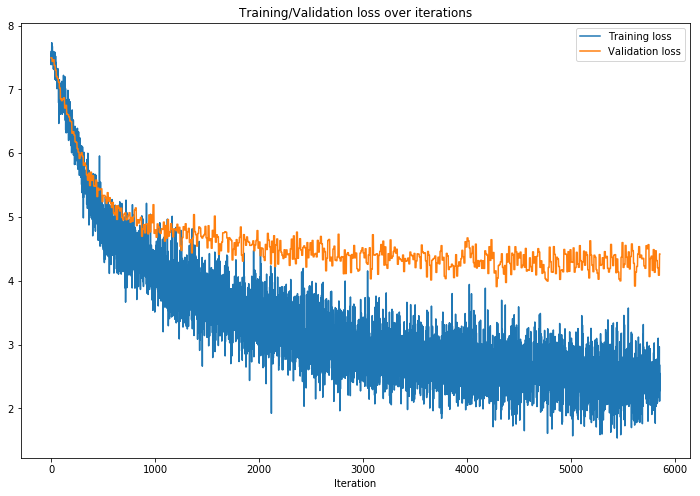

In [24]:
plt.plot(training_loss_list, label='Training loss')
plt.plot(validation_loss_list, label='Validation loss')
plt.xlabel('Iteration')
plt.title('Training/Validation loss over iterations')
plt.legend()
plt.show()

### Create log file

In [25]:
logfile_directory = 'logs/'

In [26]:
validation_loss_list = np.array(validation_loss_list)
min_valid_loss = np.inf
min_valid_loss_iteration = -1
for i in range(validation_step*5, len(validation_loss_list)-validation_step*5)[::validation_step]:
    valid_loss_mean = np.nanmean(validation_loss_list[i-validation_step*5:i+validation_step*5]) # smoothed validation mean
    if valid_loss_mean < min_valid_loss:
        min_valid_loss = valid_loss_mean
        min_valid_loss_iteration = i
min_valid_loss, min_valid_loss_iteration

(4.1682887, 4330)

In [27]:
train_loss_mean = np.nanmean(np.array(np.array(training_loss_list)[-50:]))
valid_loss_mean = np.nanmean(np.array(np.array(validation_loss_list)[-50:]))
train_loss_mean, valid_loss_mean

(2.4285424, 4.2648253)

In [28]:
date = time.strftime("%Y-%m-%d %H.%M")
logfile_name ="Logfile (Date={}, MinValidLoss={:.2f}, TrainLoss={:.2f}, Iterations={}).txt". \
    format(date, min_valid_loss, train_loss_mean, len(validation_loss_list))
logfile_name

'Logfile (Date=2017-11-13 16.02, MinValidLoss=4.17, TrainLoss=2.43, Iterations=5854).txt'

In [29]:
logfile = open(logfile_directory + logfile_name, "w")

logfile.write("Training loss={:.6f}\n".format(train_loss_mean))
logfile.write("Validation loss={:.6f}\n".format(valid_loss_mean))
logfile.write("Min Validation loss={:.6f}\n".format(min_valid_loss))
logfile.write("Iteration of min validation loss={}\n\n".format(min_valid_loss_iteration))

logfile.write("Iterations trained={}\n".format(train_loss_mean))
logfile.write("Duration={}\n".format(time_elapsed_list[-1]))

logfile.write("Number of training examples={}\n".format(len(training_data)))
logfile.write("Number of validation examples={}\n".format(len(validation_data)))


logfile.write("Batch size={}\n".format(batch_size))
logfile.write("Learning rate={:.6f}\n".format(learning_rate))
logfile.write("Number of input (T)={}\n".format(n_input))

logfile.write("Number of hidden layers={}\n".format(n_layers))
logfile.write("Number of hidden units per year={}\n\n".format(n_hidden))

for i in range(len(training_loss_list)):
    logfile.write("Iter={}, Training Loss={:.6f}, Validation Loss={:.6f}, Time Elapsed={}".format(
            (i+1), training_loss_list[i], validation_loss_list[i], time_elapsed_list[i]))
    
logfile.close()

### Generate music from trained model

In [46]:
N_GENERATED_NOTE_VECTORS = 1000
temperature = 1.0

In [47]:
state_placeholder = tf.placeholder(tf.float32, [n_layers, 2, 1, n_hidden])
l = tf.unstack(state_placeholder, 2, 0)
rnn_tuple_state = tuple([tf.nn.rnn_cell.LSTMStateTuple(l[i][0], l[i][1]) for i in range(n_layers)])

outputs_generation, states_generation = rnn.static_rnn(rnn_cell, [x_generation], 
                                                       initial_state=rnn_tuple_state, dtype=tf.float32)

logits_generation = tf.nn.xw_plus_b(outputs_generation[0], softmax_w, softmax_b)

In [48]:
seed_note = training_data[int(len(training_data)*np.random.random())][0]
seed_note = np.reshape(seed_note, [1, vocab_size])

Previous note: [ 60.]
Posterior probability: [  2.86076852e-06   8.16844749e-06   8.93860215e-06 ...,   1.29034806e-05
   4.46390186e-06   1.65280011e-02]


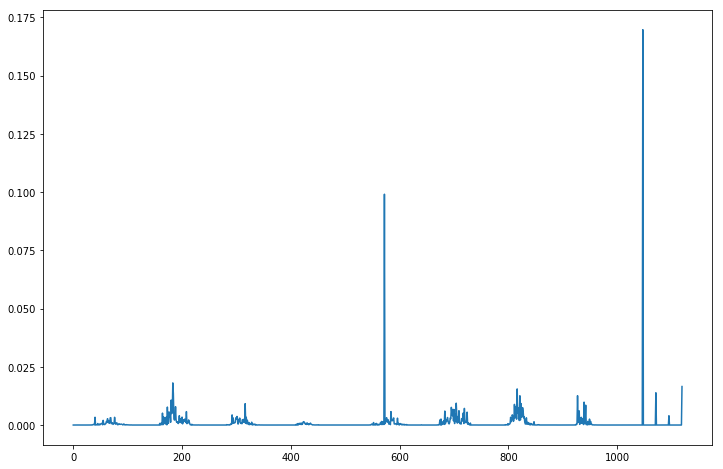

Previous note: [ 164.]
Posterior probability: [  1.93239657e-06   1.85037675e-06   5.31750493e-06 ...,   9.41290864e-07
   4.44515172e-06   2.55352389e-02]


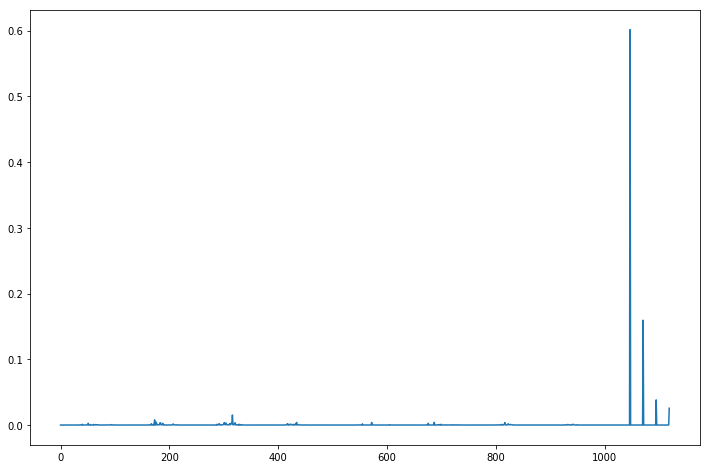

Previous note: [ 1047.]
Posterior probability: [  6.54019686e-07   4.96261123e-07   3.87552791e-06 ...,   2.16520846e-07
   3.46168633e-07   5.92920347e-04]


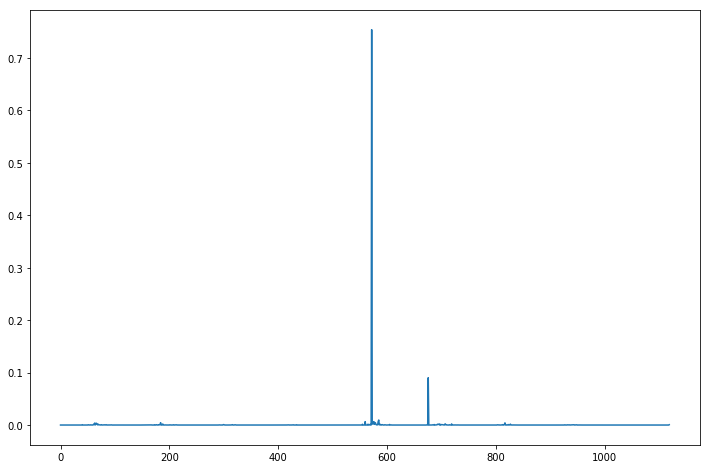

Previous note: [ 572.]
Posterior probability: [  1.92037314e-05   1.46191974e-06   6.65249854e-06 ...,   1.53260703e-06
   3.26241616e-06   8.48683179e-04]


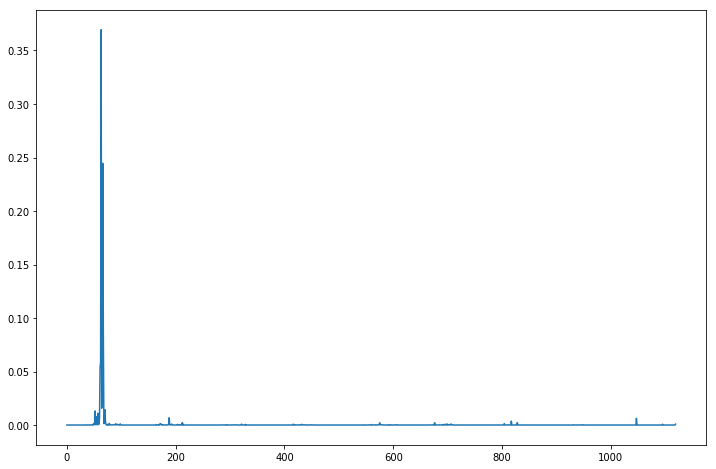

In [49]:
generated_music = [seed_note]
saved_state = np.zeros((n_layers, 2, 1, n_hidden))
for i in range(N_GENERATED_NOTE_VECTORS):
    onehot_pred, new_state = session.run([logits_generation, states_generation], 
                                         feed_dict={x_generation: generated_music[-1], state_placeholder: saved_state})
    saved_state = new_state
    next_note = np.zeros(vocab_size)
    #index = np.argmax(onehot_pred, 1) # take max probability
    softmax_cdf = np.exp(onehot_pred[0]/temperature)/np.sum(np.exp(onehot_pred[0]/temperature))
    
    if i < 4:
        print("Previous note:", generated_music[-1].dot(range(1120)))
        print("Posterior probability:", softmax_cdf)
        plt.plot(softmax_cdf)
        plt.show()
        
    index = np.random.choice(range(vocab_size), p=softmax_cdf) # choose probabilistically
    
    next_note[index] = 1
    next_note = np.reshape(next_note, [1, vocab_size])
    
    generated_music.append(next_note)

In [50]:
notes = np.array(generated_music).reshape(N_GENERATED_NOTE_VECTORS+1, vocab_size).dot(np.array(range(vocab_size)))
notes

array([   60.,   164.,  1047., ...,   167.,   724.,   679.])

### Convert generated music to midi

In [51]:
def get_track_sequences(vector_sequence):
    """Get note sequences for each track from vector sequence output from RNN.

    Args:
       vector_sequence: List of one-hot vectors containing 128 * NUM_TRACKS note_on events, 128 * NUM_TRACKS note_off events,
        and NUM_TIMESHIFTS timeshift events in intervals of 1/96 of a beat each.
       
    Returns:
        List of track vector sequences.
    """
    track_sequences = [[] for _ in range(NUM_TRACKS)]
    start_time = 0
    for vector in vector_sequence:
        index = vector.index(1)
        # vector is a time event.
        if index >= NUM_MIDI_PITCHES * 2 * NUM_TRACKS:
            num_beats = (index - NUM_MIDI_PITCHES * 2 * NUM_TRACKS + 1) / NUM_TIMESHIFTS
            start_time += num_beats
        else:
            # vector is a note_off event.
            if index >= NUM_MIDI_PITCHES * NUM_TRACKS:
                note_type = 'note_off'
                index -= NUM_MIDI_PITCHES * NUM_TRACKS
            # vector is a note_on event.
            else:
                note_type = 'note_on'
            track_num = int(index / NUM_MIDI_PITCHES)
            note = index % NUM_MIDI_PITCHES
            track_sequences[track_num].append({"type": note_type, "note": note, "start_time": start_time})
            time_delay = 0
            
    return track_sequences
    

In [52]:
def get_midi_from_vector_sequence(track_sequences):
    """Get midi from track sequences.

    Args:
       track_sequences: List of vector sequences for each track.
       
    Returns:
        MidiFile object.
    """
    mid = mido.MidiFile()
    tracks = [mido.MidiTrack() for _ in range(NUM_TRACKS)]
    mid.tracks.extend(tracks)

    for i, ts in enumerate(track_sequences):
        prev_start_time = 0
        for event in ts:
            time = event["start_time"] - prev_start_time
            prev_start_time = event["start_time"]
            # I picked a random number for velocity.
            mid.tracks[i].append(mido.Message(event["type"], note=event["note"], velocity=50,
                                              time=int(time * TICKS_PER_BEAT)))
    
    return mid

In [53]:
track_sequence = get_track_sequences([list(x[0]) for x in generated_music])

In [54]:
track_sequence[1]

[{'note': 36, 'start_time': 0, 'type': 'note_on'},
 {'note': 64, 'start_time': 1.0, 'type': 'note_on'},
 {'note': 64, 'start_time': 1.25, 'type': 'note_off'},
 {'note': 45, 'start_time': 1.25, 'type': 'note_off'},
 {'note': 67, 'start_time': 1.5, 'type': 'note_off'},
 {'note': 47, 'start_time': 3.5, 'type': 'note_on'},
 {'note': 65, 'start_time': 4.25, 'type': 'note_off'},
 {'note': 64, 'start_time': 4.25, 'type': 'note_on'},
 {'note': 64, 'start_time': 4.75, 'type': 'note_off'},
 {'note': 33, 'start_time': 4.75, 'type': 'note_on'},
 {'note': 24, 'start_time': 5.25, 'type': 'note_on'},
 {'note': 64, 'start_time': 5.75, 'type': 'note_off'},
 {'note': 64, 'start_time': 5.75, 'type': 'note_on'},
 {'note': 64, 'start_time': 6.75, 'type': 'note_off'},
 {'note': 64, 'start_time': 6.75, 'type': 'note_on'},
 {'note': 64, 'start_time': 7.75, 'type': 'note_off'},
 {'note': 67, 'start_time': 7.75, 'type': 'note_on'},
 {'note': 53, 'start_time': 7.75, 'type': 'note_off'},
 {'note': 61, 'start_time

In [55]:
midi = get_midi_from_vector_sequence(track_sequence)
midi

<midi file None type 1, 4 tracks, 864 messages>

# Save midi

In [56]:
generation_output = "generated_music/"

In [57]:
midi_name = "Generated Music (Date={}, Temperature={}, Length={}, MinValidLoss={:.2f}, TrainLoss={:.2f}, Iterations={}).mid". \
    format(date, temperature, N_GENERATED_NOTE_VECTORS, min_valid_loss, train_loss_mean, len(validation_loss_list))
midi_name

'Generated Music (Date=2017-11-13 16.03, Temperature=1.0, Length=1000, MinValidLoss=4.17, TrainLoss=2.43, Iterations=5854).mid'

In [58]:
midi.save(generation_output + midi_name)